In [1]:
import sagemaker
from sagemaker import get_execution_role
role=get_execution_role()

In [5]:
import os
import torch
import torchvision

In [26]:
import io
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
#!aws s3 sync s3://experimental-bkt/only-500-images images/super_res/

In [6]:
imgs_list=[]
for i in os.listdir('images/crappified/crap/'):
    if i.endswith('.jpg'):
        imgs_list.append(i)

# Making a custom dataset

In [75]:
from torchvision.utils import make_grid
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [42]:
class CustomDataset(torch.utils.data.Dataset):
    
    def __init__(self,root_dir,imgs_list,transform=None):
        
        self.root_dir=root_dir
        self.imgs_list=imgs_list
        self.transform=transform
        
    def __len__(self):
        return len(os.listdir(self.root_dir))
    
    def __getitem__(self,idx):
        
        if torch.is_tensor(idx):
            idx=idx.tolist()
        
        super_res_img_name=os.path.join(self.root_dir,'super_res/real/{}'.format(self.imgs_list[idx]))
        crappified_img_name=os.path.join(self.root_dir,'crappified/crap/{}'.format(self.imgs_list[idx]))
        
        super_img=Image.open(super_res_img_name)
        crap_img=Image.open(crappified_img_name)
        
        sample={'super-res':super_img,'crap-img':crap_img}
        
        if self.transform:
            sample={'super-res':self.transform(sample['super-res']),'crap-img':self.transform(sample['crap-img'])}
        
        return sample
        
        

In [43]:
from torchvision import transforms

In [44]:
trans=transforms.Compose([transforms.ToTensor()])
datasett=CustomDataset('images/',imgs_list,transform=trans)

In [83]:
from torch.utils.data import DataLoader
dataloader = DataLoader(datasett, batch_size=5,
                        shuffle=True, num_workers=0)


0 torch.Size([3, 3, 218, 178]) torch.Size([3, 3, 70, 60])


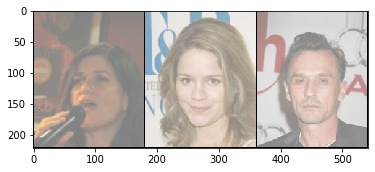

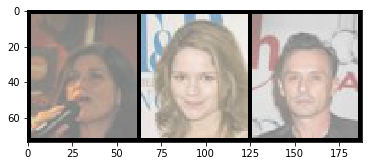

In [84]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['super-res'].size(),
          sample_batched['crap-img'].size())
    
    #ax=plt.subplot(1,3,i+1)
    plt.tight_layout()
    #ax.imshow(sample_batched['crap-img'].permute(1,2,0))
    show_tensor_images(sample_batched['super-res'])
    show_tensor_images(sample_batched['crap-img'])

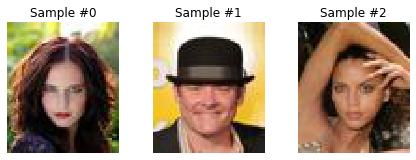

In [52]:
for i in range(len(datasett)):
    sample = datasett[i+10]
    #print(i, sample['super-res'].shape, sample['crap-img'].shape)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    ax.imshow(sample['super-res'].permute(1,2,0))
    ax.imshow(sample['crap-img'].permute(1,2,0))

    if i == 10:
        plt.show()
        break

In [32]:
sample

{'super-res': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=178x218 at 0x7F5B4440EC88>,
 'crap-img': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x70 at 0x7F5B4440ECF8>}